In [10]:
import glob
import re
import boto3
import sys
sys.path.append('/home/ec2-user/DAWN/DJA-SEpp')
import importlib
starsex = importlib.import_module("02_SExtractor")
psfex = importlib.import_module("03_PSFEx")

In [11]:
field = 'GDS'

In [ ]:
# F200W Point-like sources detection
filter = 'f200w'

starsex.extract_stars(detect_img      = glob.glob(f"/FlashStorage/image/{field}/*{filter}*sci.fits")[0], \
                      weight_img      = glob.glob(f"/FlashStorage/image/{field}/*{filter}*wht.fits")[0], \
                      output_cat      = f"/FlashStorage/catalog/{field}/{field}_drc_cat.fits", \
                      output_cat_star = f"/FlashStorage/catalog/{field}/{field}_drc_cat_star.fits", \
                      config_file     = "/home/ec2-user/DAWN/DJA-SEpp/config/PSFEx-Cat-JWST.sex", \
                      params_file     = "/home/ec2-user/DAWN/DJA-SEpp/config/PSFEx-Cat-JWST-SW.param", \
                      dir_chckimg     = f"/FlashStorage/catalog/{field}/checkimages", \
                      detect_thresh = 8.0, \
                      y_max = -5.0, \
                      save_chckimg = False, plot = True, clean = True, verbose = True)

In [4]:
# Save star catalog to S3
s3 = boto3.client('s3')
s3.upload_file(f"/FlashStorage/catalog/{field}/{field}_drc_cat_star.fits", 'aurelien-sepp', f"catalog/{field}/{field}_drc_cat_star.fits")

In [13]:
# PSF in other images
# filter_list = ['f090w', 'f115w', 'f150w', 'f182m', 'f200w', 'f210m', 'f277w', 'f335m', 'f356w', 'f410m', 'f444w']
filter_list = [re.search('(f\d+\w+)', filename).group(1) for filename in glob.glob(f"/FlashStorage/image/{field}/*sci*")]
filter_list.sort()
filter_list

['f090w',
 'f115w',
 'f150w',
 'f182m',
 'f200w',
 'f210m',
 'f250m',
 'f277w',
 'f300m',
 'f335m',
 'f356w',
 'f410m',
 'f430m',
 'f444w',
 'f460m',
 'f480m']

In [ ]:
for filter in filter_list:
    print(filter.upper())
    print("Running SExtractor")
    starsex.extract_stars_catalog(detect_img      = glob.glob(f"/FlashStorage/image/{field}/*{filter}*sci.fits")[0], \
                                  weight_img      = glob.glob(f"/FlashStorage/image/{field}/*{filter}*wht.fits")[0], \
                                  output_cat      = f"/FlashStorage/catalog/{field}/{field}-{filter}-clear_drc_cat.fits", \
                                  output_cat_star = f"/FlashStorage/catalog/{field}/{field}-{filter}-clear_drc_cat_star.fits", \
                                  input_cat_star  = f"/FlashStorage/catalog/{field}/{field}_drc_cat_star.fits", \
                                  config_file     = "/home/ec2-user/DAWN/DJA-SEpp/config/PSFEx-Cat-JWST.sex", \
                                  params_file     = "/home/ec2-user/DAWN/DJA-SEpp/config/PSFEx-Cat-JWST-SW.param", \
                                  dir_chckimg     = f"/FlashStorage/checkimages/{field}", \
                                  detect_thresh = 2.5, \
                                  save_chckimg = False, plot = False, clean = True, run_sex = True, verbose = True)
    print("Running PSFEX")
    psfex.run_psfex(cat_name    = f"/FlashStorage/catalog/{field}/{field}-{filter}-clear_drc_cat_star.fits",
                    output_cat  = f"/FlashStorage/catalog/{field}/{field}-{filter}-clear_drc_cat_star_psf.fits",
                    dir_chckimg = f"/FlashStorage/checkimages/{field}",
                    dir_psfex   = f"/FlashStorage/psfex/{field}",
                    config_file = "/home/ec2-user/DAWN/DJA-SEpp/config/psfex_default.conf",
                    fwhm_range  = '1.0, 10.0',
                    save_psf_png = True,
                    verbose = True)

## Visualize all PSFs

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from matplotlib import patheffects
from astropy.io import fits

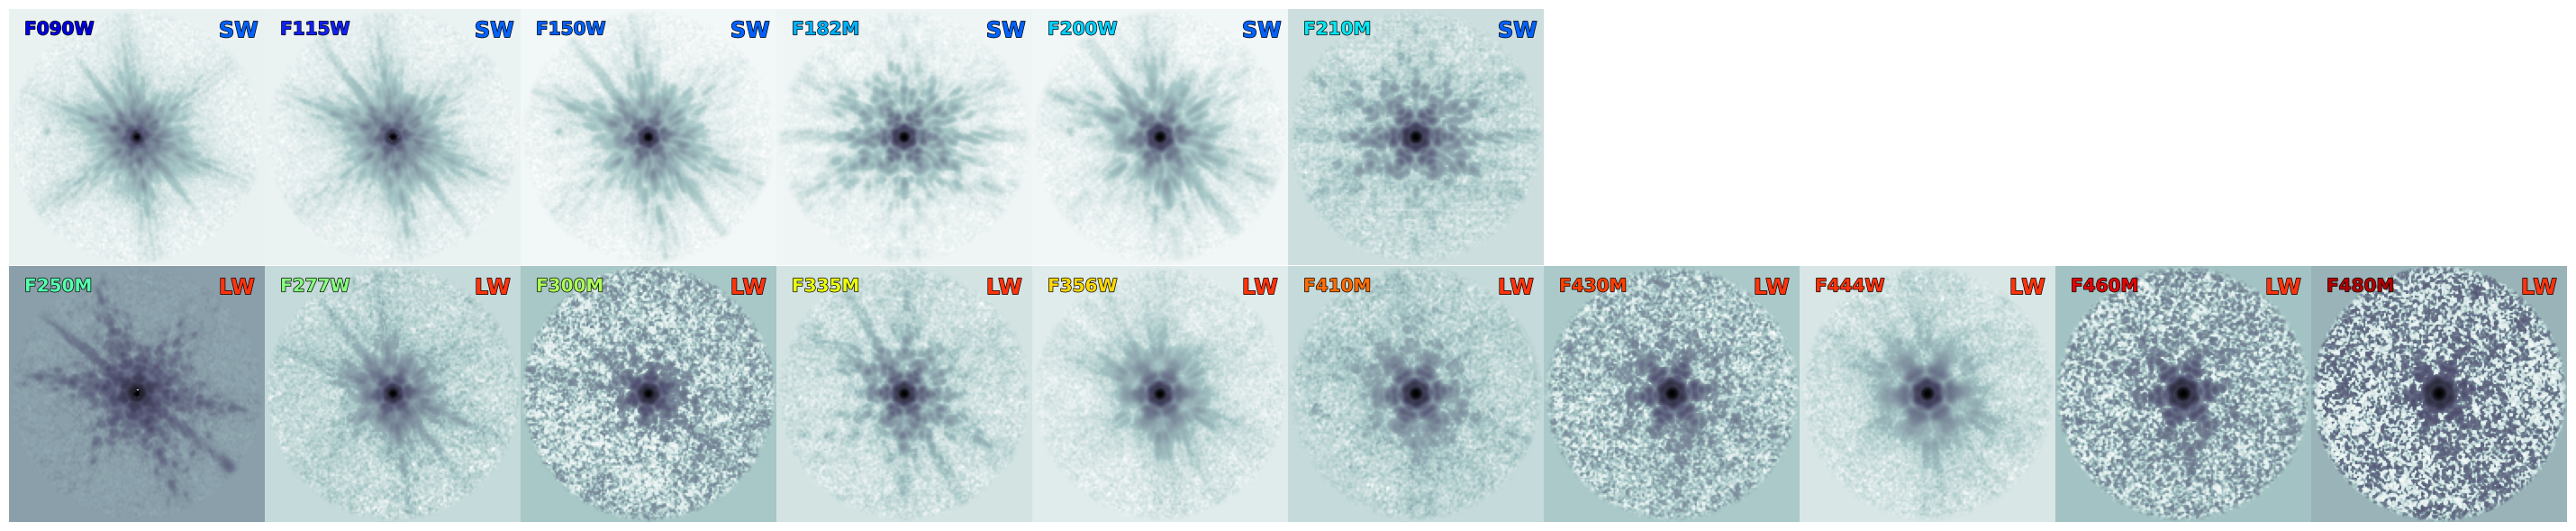

In [17]:
color_dict = {'F090W':'#0000E3', 
              'F115W':'#1020FF',
              'F150W':'#0162FF',
              'F182M':'#00B1FF',
              'F200W':'#04D1FF',
              'F210M':'#02E8F4',
              'F250M':'#55FFAE',
              'F277W':'#87FF7F',
              'F300M':'#AAFF57',
              'F335M':'#EBFF0C',
              'F356W':'#FFD807',
              'F410M':'#FF6D03',
              'F430M':'#FF3F00',
              'F444W':'#FF330C',
              'F460M':'#DF0606',
              'F480M':'#B20000',}
channel_dict = {'F090W':'SW', 'F115W':'SW', 'F150W':'SW', 'F182M':'SW', 'F200W':'SW', 'F210M':'SW',
                'F250M':'LW', 'F277W':'LW', 'F300M':'LW', 'F335M':'LW', 'F356W':'LW', 'F410M':'LW', 'F430M':'LW', 'F444W':'LW', 'F460M':'LW', 'F480M':'LW'}
channel_color_dict = {'SW' : '#0162FF', 'LW' : '#FF330C'}

channel, count = np.unique([channel_dict[filter.upper()] for filter in filter_list], return_counts=True)
channel_count = dict(zip(channel, count))

w = channel_count[max(channel_count, key=channel_count.get)]
h = len(channel_count)

fig, axs = plt.subplots(h,w,figsize=(2.87*w,3*h), sharex=True, sharey=True, gridspec_kw = {'wspace':0, 'hspace':0})
for i, filter in enumerate(filter_list):
    image = fits.open(glob.glob(f"/FlashStorage/psfex/{field}/*{filter}*star_psf.psf")[0])
    psf = image[1].data[0][0][0]
    image.close()
    
    if (len(channel_count)==2) & (channel_dict[filter.upper()]=="LW"):
        i += max(0, channel_count["LW"]-channel_count["SW"])
    ax = axs.flatten()[i] if type(axs)==np.ndarray else axs
    ax.set_axis_off()
    ax.imshow(psf, origin='lower', cmap='bone_r', norm=SymLogNorm(linthresh=1e-5, linscale=0.8))
    ax.text(0.06, 0.9, filter.upper(), transform=ax.transAxes, 
            fontsize='x-large', fontweight='bold', 
            color=color_dict[filter.upper()],
            path_effects=[patheffects.withStroke(linewidth=1, foreground="k")])
    ax.text(0.82, 0.89, channel_dict[filter.upper()], transform=ax.transAxes, 
            fontsize='xx-large', fontweight='bold', 
            color=channel_color_dict[channel_dict[filter.upper()]],
            path_effects=[patheffects.withStroke(linewidth=1, foreground="k")])

if type(axs)==np.ndarray:
    for j in range(len(filter_list), len(axs.flatten())):
        offset = -w if max(channel_count, key=channel_count.get)=="LW" else 0
        fig.delaxes(axs.flatten()[j+offset])
    
fig.tight_layout()
# fig.savefig(f"/home/ec2-user/DAWN/DJA-SEpp/psfex/GDS/PSF_summary_{field}.pdf", bbox_inches='tight', pad_inches=0)
# fig.savefig(f"/home/ec2-user/DAWN/DJA-SEpp/psfex/GDS/PSF_summary_{field}.png", bbox_inches='tight', pad_inches=0, dpi=100)
plt.show()

### Save all PSFs to make GIF

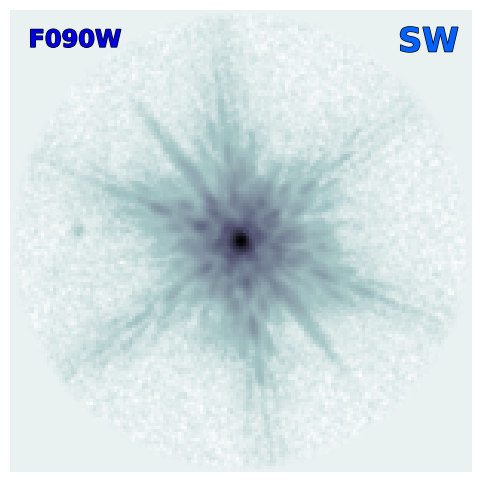

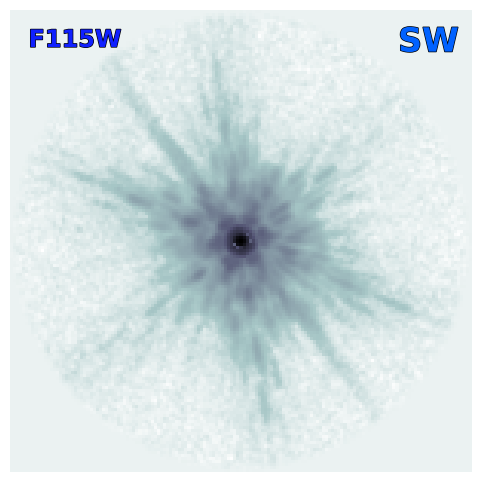

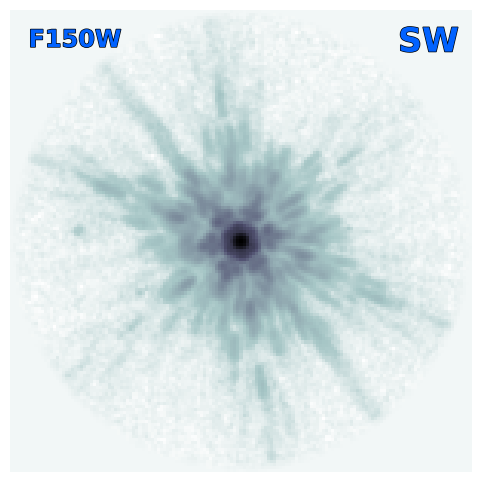

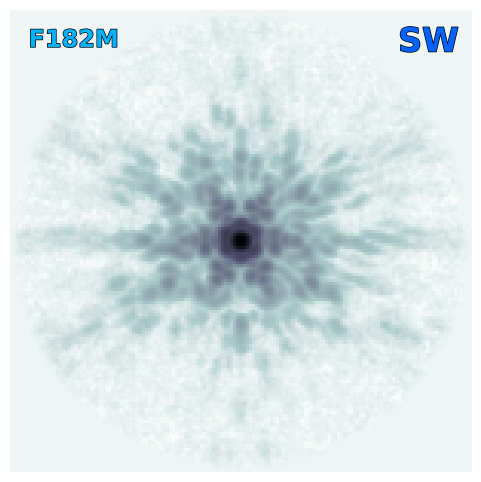

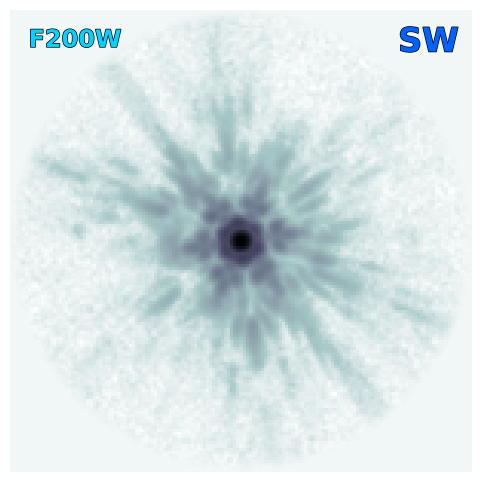

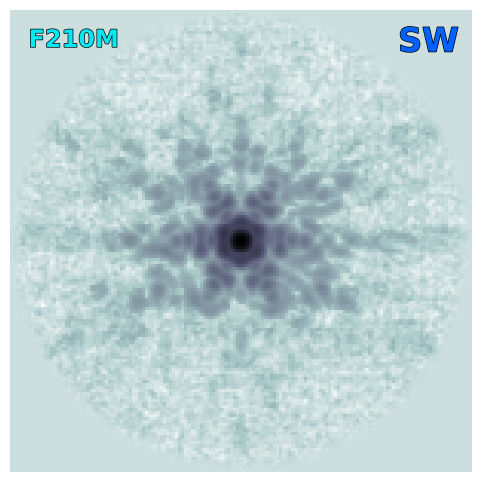

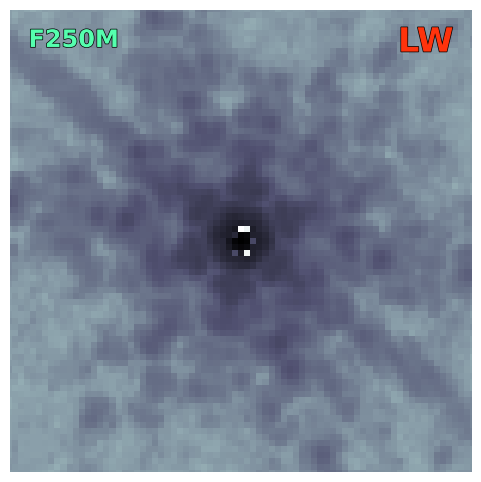

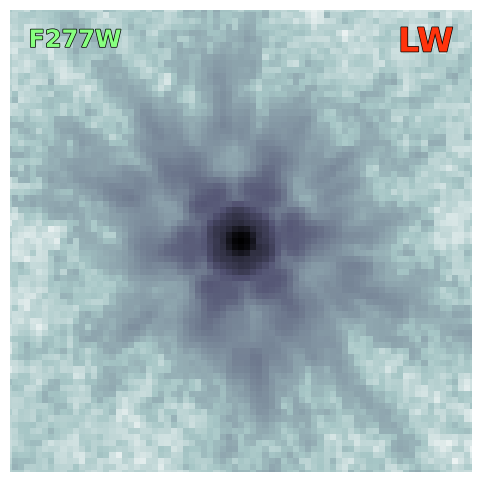

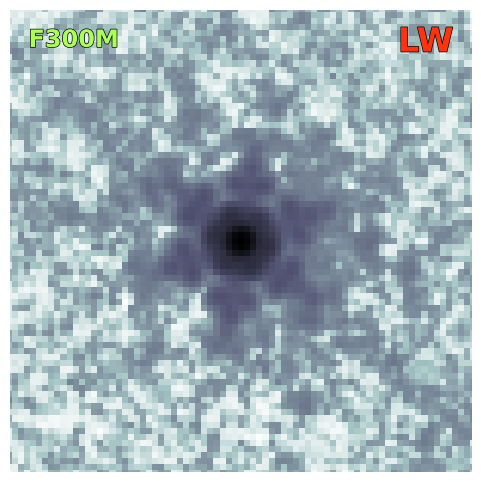

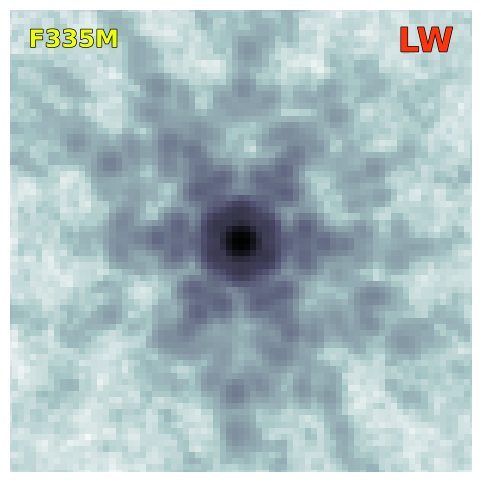

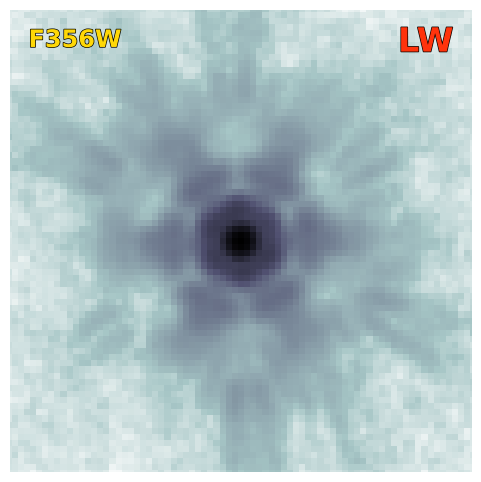

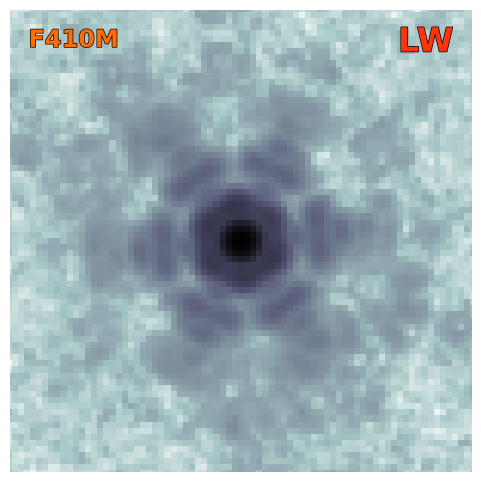

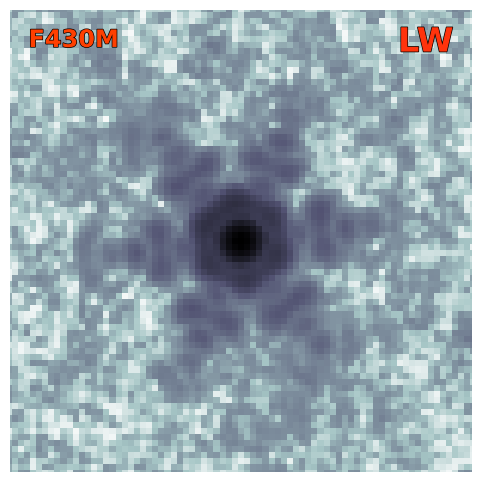

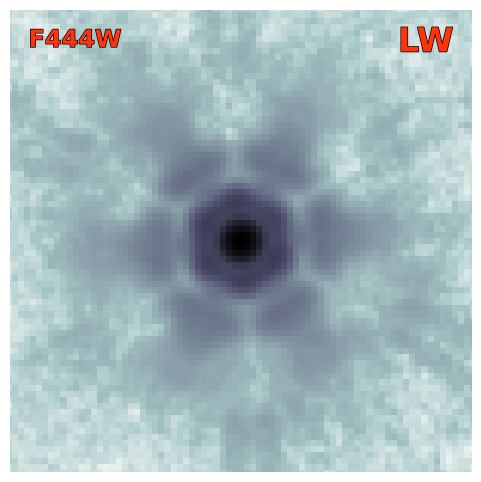

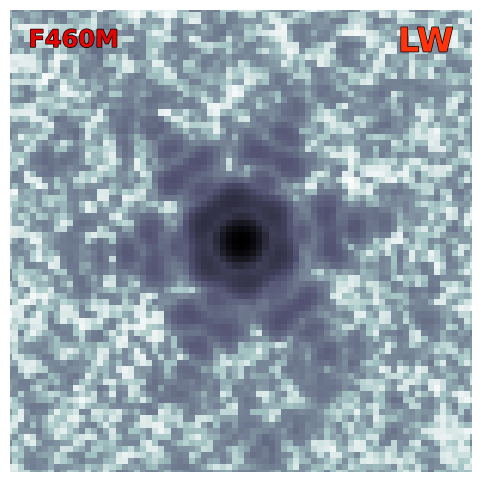

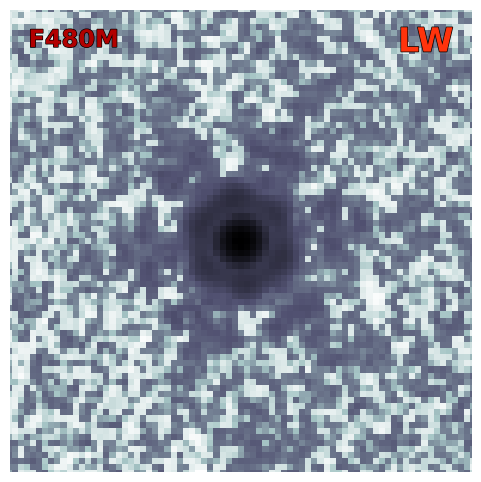

In [18]:
for filter in filter_list:
    image = fits.open(glob.glob(f"/home/ec2-user/DAWN/DJA-SEpp/psfex/{field}/*{filter}*star_psf.psf")[0])
    psf = image[1].data[0][0][0]
    image.close()

    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_axis_off()
#     extent = (-100,100,-100,100) # No scaling
    extent = (-100,100,-100,100) if channel_dict[filter.upper()]=='SW' else (-200,200,-200,200) # Same pixel scale
    ax.imshow(psf, origin='lower', cmap='bone_r', norm=SymLogNorm(linthresh=1e-5, linscale=0.8), extent=extent)
    ax.set_xlim(-100,100)
    ax.set_ylim(-100,100)
    ax.text(0.04, 0.92, filter.upper(), transform=ax.transAxes, 
            fontsize='xx-large', fontweight='bold', 
            color=color_dict[filter.upper()],
            path_effects=[patheffects.withStroke(linewidth=1, foreground="k")])
    ax.text(0.84, 0.91, channel_dict[filter.upper()], transform=ax.transAxes, 
            fontsize=24, fontweight='bold', 
            color=channel_color_dict[channel_dict[filter.upper()]],
            path_effects=[patheffects.withStroke(linewidth=1, foreground="k")])
    # fig.savefig(f"/home/aurelien/DAWN/DJA_SE++/validation-images/5_PSF/{filter}.png", bbox_inches='tight', pad_inches=0, dpi=100) # No scaling
    # fig.savefig(f"/home/aurelien/DAWN/DJA_SE++/validation-images/5_PSF/scaled_{filter}.png", bbox_inches='tight', pad_inches=0, dpi=100) # Same pixel scale

    plt.show()